**Projet 7 - Implémentez un modèle de scoring**

*Auteur : Berechet Stefan, Formation OpenClassrooms Data Scientist 9 mois du 13 novembre 2020 au 13 août 2021* 


**Objectif du Projet :**

    Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
    
    Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.


In [1]:
# importation bibliothéques utiles
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
import gc
import warnings
import time
warnings.filterwarnings("ignore")

# **Partie 2 - Modélisation**

## **Chargement des données**

In [2]:
data = pd.read_csv('application_train_all_features.csv')

In [3]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total

In [4]:
# Remplacement valeurs infinies
data.replace([np.inf, -np.inf], np.nan, inplace=True)

## Traitement des données manquantes

In [5]:
# Fonction données manquantes
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)

In [6]:
find_missing(data).sort_values(['missing_ratio'], ascending=False).head(20)

,missing_count,missing_ratio
ccb_avg_drawing_amount,248339,0.807578
bur_avg_term,247239,0.804001
ccb_cur_total_limit,230816,0.750594
bur_avg_annuity,227502,0.739817
ccb_count_rej,220606,0.717392
ccb_total_limit_card,220606,0.717392
ccb_total_dpd_days,220606,0.717392
ccb_max_dpd_days,220606,0.717392
ccb_drawing_times_6m,220606,0.717392
ccb_drawing_amount_6m,220606,0.717392


In [7]:
# Suppression des features avec plus de 25% de données manquantes
data = data.loc[:, data.isnull().mean() < .25]
data.shape 

(307511, 316)

In [8]:
find_missing(data).sort_values(['missing_ratio'], ascending=False).head(5)

,missing_count,missing_ratio
pcb_max_dpd_days_2y,62077,0.201869
pcb_total_largedpd_days_2y,62077,0.201869
pcb_max_largedpd_days_2y,62077,0.201869
pcb_total_dpd_days_2y,62077,0.201869
EXT_SOURCE_3,60965,0.198253


### Extraction type variables

In [9]:
# Fonction pour extraire le type des variables
def feature_type_split(data, special_list=[]):
    cat_list = []
    #dis_num_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        #elif data[i].nunique() < 25:
        #    dis_num_list.append(i)
       # elif i in special_list:     # if you want to add some special cases
        #    dis_num_list.append(i)
        else:
            num_list.append(i)
    return cat_list, num_list

In [10]:
# Extraction type des variables
cat_list, num_list = feature_type_split(data)

### Simple_Imputer

In [11]:
# vérification si données manquantes sur l'ID et la cible
find_missing(data[['SK_ID_CURR','TARGET']]).sort_values(['missing_ratio'], ascending=False)

,missing_count,missing_ratio
SK_ID_CURR,0,0.0
TARGET,0,0.0


In [12]:
# SimpleImputer
from sklearn.impute import SimpleImputer

# variables numériques
data_num = data[num_list]

imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')

imputer_median.fit(data_num)
ar_data_num = imputer_median.transform(data_num)

data_num = pd.DataFrame(ar_data_num, columns=data_num.columns)
#data_num


# variables catégorielles
data_cat = data[cat_list]

imputer_mostfreq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer_mostfreq.fit(data_cat)
ar_data_cat = imputer_mostfreq.transform(data_cat)


data_cat = pd.DataFrame(ar_data_cat, columns=data_cat.columns)
data_cat



,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,THURSDAY,Religion
...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,THURSDAY,Services
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,MONDAY,XNA
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,THURSDAY,School
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,WEDNESDAY,Business Entity Type 1


### Transformation des variables catégorielles (Dummies)

In [13]:
# Dummies sur les variables catégorielles
data_cat_dummies = pd.get_dummies(data_cat)
data_cat_dummies

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0

In [14]:
data_clean = pd.merge(data_num, data_cat_dummies, left_index=True, right_index=True)
data_clean

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_total_max_overdue_adj,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_total_annuity,bur_active_total_annuity,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_total_overdue_month,bb_total_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_total_score,ip_prev_count,ip_payment_count,ip_creditcard_user,ip_creditcard_count,ip_total_change_times,ip_avg_change_times,ip_avg_instl,ip_max_instl,ip_total_late_times,ip_total_less_times,ip_total_late_days,ip_total_less_amount,ip_total_actual_payment,ip_total_required_payment,ip_recent_term,ip_recent_total_actual_payment,ip_recent_total_required_payment,ip_recent_total_late_times,ip_recent_total_less_times,ip_recent_total_late_days,ip_recent_total_less_amount,ip_active_1y,ip_active_6m,ip_count_1y__Cash loans,ip_count_1y__Consumer loans,ip_count_1y__Revolving loans,ip_count_6m__Cash loans,ip_count_6m__Consumer loans,ip_count_6m__Revolving loans,pcb_prev_count,pcb_avg_month,pcb_recent_active,pcb_inst_change_time,pcb_avg_inst,pcb_active_inst,pcb_max_dpd_days,pcb_total_dpd_days,pcb_max_largedpd_days,pcb_total_largedpd_days,pcb_max_dpd_days_2y,pcb_total_dpd_days_2y,pcb_max_largedpd_days_2y,pcb_total_largedpd_days_2y,pcb_end_as_Amortized debt,pcb_end_as_Approved,pcb_end_as_Canceled,pcb_end_as_Completed,pcb_end_as_Demand,pcb_end_as_Returned to the store,pcb_end_as_Signed,pcb_no_dpd,pcb_no_largedpd,pcb_no_dpd_1y,pcb_no_largedpd_1y,pcb_no_dpd_2y,pcb_no_largedpd_2y,pa_prev_count,pa_avg_annuity,pa_avg_application,pa_avg_actual_credit,pa_max_application,pa_max_actual_credit,pa_total_annuity,pa_total_application,pa_total_actual_credit,pa_not_full_credit_times,pa_not_f

In [15]:
find_missing(data_clean).sort_values(['missing_ratio'], ascending=False).head(10)

,missing_count,missing_ratio
SK_ID_CURR,0,0.0
pa_CODE_REJECT_REASON_SYSTEM,0,0.0
pa_NAME_PRODUCT_TYPE_walk-in,0,0.0
pa_NAME_PORTFOLIO_POS,0,0.0
pa_NAME_PORTFOLIO_Cash,0,0.0
pa_NAME_PORTFOLIO_Cars,0,0.0
pa_NAME_PORTFOLIO_Cards,0,0.0
pa_NAME_CLIENT_TYPE_Repeater,0,0.0
pa_NAME_CLIENT_TYPE_Refreshed,0,0.0
pa_NAME_CLIENT_TYPE_New,0,0.0


In [16]:
del data, data_num, data_cat_dummies

In [17]:
import re
data_clean = data_clean.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


## Feature Selection 

Utilisation et inspiration du kernenl kaggle https://github.com/oskird/Kaggle-Home-Credit-Default-Risk-Solution


- select **nb_features** from 545
- **xxx_support**: list to represent select this feature or not
- **xxx_feature**: the name of selected features


***Si déja réalisé, aller directement au chargement de la liste des features retenues 1.3.6***

In [18]:
X = data_clean.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = data_clean.TARGET

feature_name = X.columns.tolist()

### Feature matrix and target

In [21]:
data_clean

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_total_max_overdue_adj,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_total_annuity,bur_active_total_annuity,bur_Active,bur_Baddebt,bur_Closed,bur_Sold,bur_currency1,bur_currency2,bur_currency3,bur_currency4,bur_Anothertypeofloan,bur_Carloan,bur_Cashloannonearmarked,bur_Consumercredit,bur_Creditcard,bur_Interbankcredit,bur_Loanforbusinessdevelopment,bur_Loanforpurchaseofsharesmarginlending,bur_Loanforthepurchaseofequipment,bur_Loanforworkingcapitalreplenishment,bur_Microloan,bur_Mobileoperatorloan,bur_Mortgage,bur_Realestateloan,bur_Unknowntypeofloan,bb_total_overdue_month,bb_total_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_total_score,ip_prev_count,ip_payment_count,ip_creditcard_user,ip_creditcard_count,ip_total_change_times,ip_avg_change_times,ip_avg_instl,ip_max_instl,ip_total_late_times,ip_total_less_times,ip_total_late_days,ip_total_less_amount,ip_total_actual_payment,ip_total_required_payment,ip_recent_term,ip_recent_total_actual_payment,ip_recent_total_required_payment,ip_recent_total_late_times,ip_recent_total_less_times,ip_recent_total_late_days,ip_recent_total_less_amount,ip_active_1y,ip_active_6m,ip_count_1y__Cashloans,ip_count_1y__Consumerloans,ip_count_1y__Revolvingloans,ip_count_6m__Cashloans,ip_count_6m__Consumerloans,ip_count_6m__Revolvingloans,pcb_prev_count,pcb_avg_month,pcb_recent_active,pcb_inst_change_time,pcb_avg_inst,pcb_active_inst,pcb_max_dpd_days,pcb_total_dpd_days,pcb_max_largedpd_days,pcb_total_largedpd_days,pcb_max_dpd_days_2y,pcb_total_dpd_days_2y,pcb_max_largedpd_days_2y,pcb_total_largedpd_days_2y,pcb_end_as_Amortizeddebt,pcb_end_as_Approved,pcb_end_as_Canceled,pcb_end_as_Completed,pcb_end_as_Demand,pcb_end_as_Returnedtothestore,pcb_end_as_Signed,pcb_no_dpd,pcb_no_largedpd,pcb_no_dpd_1y,pcb_no_largedpd_1y,pcb_no_dpd_2y,pcb_no_largedpd_2y,pa_prev_count,pa_avg_annuity,pa_avg_application,pa_avg_actual_credit,pa_max_application,pa_max_actual_credit,pa_total_annuity,pa_total_application,pa_total_actual_credit,pa_not_full_credit_times,pa_not_full_credit_rate,pa_get_more_credit_times,pa_get_more_c

### Filter
- documentation for **SelectKBest**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

####  Pearson Correlation
**Note**
- Normalization: no
- Impute missing values: yes

In [22]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [23]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


#### Chi-2

**Note**
- Normalization: MinMaxScaler (values should be bigger than 0)
- Impute missing values: yes

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x0000011482C25168>)

In [25]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


### Wrapper
- documentation for **RFE**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

**Note**
- Normalization: depend on the used model; yes for LR
- Impute missing values: depend on the used model; yes for LR


In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 409 features.
Fitting estimator with 399 features.
Fitting estimator with 389 features.
Fitting estimator with 379 features.
Fitting estimator with 369 features.
Fitting estimator with 359 features.
Fitting estimator with 349 features.
Fitting estimator with 339 features.
Fitting estimator with 329 features.
Fitting estimator with 319 features.
Fitting estimator with 309 features.
Fitting estimator with 299 features.
Fitting estimator with 289 features.
Fitting estimator with 279 features.
Fitting estimator with 269 features.
Fitting estimator with 259 features.
Fitting estimator with 249 features.
Fitting estimator with 239 features.
Fitting estimator with 229 features.
Fitting estimator with 219 features.
Fitting estimator with 209 features.
Fitting estimator with 199 features.
Fitting estimator with 189 features.
Fitting estimator with 179 features.
Fitting estimator with 169 features.
Fitting estimator with 159 features.
Fitting estimator with 149 features.
F

RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10,
    verbose=5)

In [27]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


### Embeded
- documentation for **SelectFromModel**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html


#### Logistics Regression L2
**Note**
- Normalization: Yes
- Impute missing values: Yes

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(), threshold='1.25*median')

In [29]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

180 selected features


#### Random Forest
**Note**
- Normalization: No
- Impute missing values: Yes

In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [31]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

183 selected features


#### LightGBM
**Note**
- Normalization: No
- Impute missing values: No

In [32]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(colsample_bytree=0.2,
                                         learning_rate=0.05,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         num_leaves=32, reg_alpha=3,
                                         reg_lambda=1),
                threshold='1.25*median')

In [33]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

191 selected features


### Summary

In [34]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(10)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,pa_first_due_day,True,True,True,True,True,True,6
2,pa_PRODUCT_COMBINATION_CashXSelllow,True,True,True,True,True,True,6
3,ip_recent_total_late_times,True,True,True,True,True,True,6
4,bur_act_count,True,True,True,True,True,True,6
5,bur_Creditcard,True,True,True,True,True,True,6
6,TOTAL_BUILDING_SCORE_AVG,True,True,True,True,True,True,6
7,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,True,True,True,True,True,True,6
8,EXT_SOURCE_3,True,True,True,True,True,True,6
9,EXT_SOURCE_2,True,True,True,True,True,True,6
10,DAYS_EMPLOYED,True,True,True,True,True,True,6


In [37]:
# Choix de Garder les features avec un score >=3
liste_features_retenues = feature_selection_df[feature_selection_df['Total']>2]['Feature'].values.tolist()

**Sauvegarde liste_features_retenues :**

### CHARGEMENT Liste Features (si déja fait)

In [18]:
import pickle
# Chargement
file_name = "liste_features_retenues.pkl"
open_file = open(file_name, "rb")
liste_features_retenues = pickle.load(open_file)
open_file.close()

In [19]:
data_clean_reduit = data_clean[['SK_ID_CURR', 'TARGET']+liste_features_retenues]
data_clean_reduit

,SK_ID_CURR,TARGET,pa_first_due_day,pa_PRODUCT_COMBINATION_CashXSelllow,ip_recent_total_late_times,bur_act_count,bur_Creditcard,TOTAL_BUILDING_SCORE_AVG,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_BIRTH,CODE_GENDER_F,BIRTH_EMPLOTED_INTERVEL,pa_total_term,pa_total_down_payment_rate,pa_max_term,pa_max_down_payment_rate,pa_avg_annuity,pa_PRODUCT_COMBINATION_POSindustrywithinterest,pa_PRODUCT_COMBINATION_CashXSellhigh,pa_PRODUCT_COMBINATION_CashStreethigh,pa_NAME_YIELD_GROUP_low_action,pa_NAME_PRODUCT_TYPE_walkin,pa_NAME_PORTFOLIO_Cards,pa_NAME_CONTRACT_TYPE_Consumerloans,pa_NAME_CONTRACT_STATUS_Refused,pa_NAME_CONTRACT_STATUS_Approved,pa_CODE_REJECT_REASON_XAP,pa_CODE_REJECT_REASON_SCOFR,pa_CODE_REJECT_REASON_LIMIT,pa_CODE_REJECT_REASON_HC,ip_total_less_times,ip_total_late_times,ip_recent_total_less_times,ip_count_6m__Revolvingloans,bur_recent_application,bur_eariliest_application,bur_avg_intervel,bur_Microloan,bur_Closed,bur_Active,REGION_RATING_CLIENT_W_CITY,NAME_EDUCATION_TYPE_Highereducation,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_ID_PUBLISH,CODE_GENDER_M,AMT_GOODS_PRICE,AMT_CREDIT,pcb_total_dpd_days_2y,pcb_max_dpd_days_2y,pcb_avg_month,pcb_avg_inst,pa_usage_length,pa_total_goods_price,pa_total_annuity_adj,pa_total_annuity,pa_total_actual_credit_adj,pa_total_actual_credit,pa_max_actual_credit,pa_last_due_day,pa_get_more_credit_times,pa_get_more_credit_rate,pa_earliest_decision_day,pa_avg_term,pa_avg_intervel,pa_avg_goods_price,pa_avg_down_payment_rate,pa_PRODUCT_COMBINATION_CardStreet,pa_NFLAG_INSURED_ON_APPROVAL_00,pa_NAME_YIELD_GROUP_low_normal,pa_NAME_YIELD_GROUP_high,pa_NAME_PORTFOLIO_POS,pa_NAME_PAYMENT_TYPE_Cashthroughthebank,pa_NAME_CONTRACT_TYPE_Revolvingloans,pa_NAME_CLIENT_TYPE_Refreshed,ip_total_less_amount,ip_total_change_times,ip_recent_total_required_payment,ip_recent_total_actual_payment,ip_payment_count,ip_max_instl,ip_creditcard_user,ip_creditcard_count,ip_avg_instl,ip_avg_change_times,bur_sd_intervel,bur_recent_update,bur_ncount,bur_active_total_limit,bur_active_avg_limit,bur_Mortgage,bur_Consumercredit,bur_Carloan,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,OVER_EXPECT_CREDIT,ORGANIZATION_TYPE_Transporttype3,ORGANIZATION_TYPE_Selfemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_Pensioner,FLAG_DOCUMENT_3,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_TOTAL,AMT_ANNUITY,pcb_prev_count,pcb_no_dpd_2y,pcb_active_inst,pa_total_application_adj,pa_total_application,pa_recent_decision_day,pa_most_frequent_term,pa_min_freq,pa_lastdue_termination_range,pa_avg_down_payment,pa_avg_application,pa_avg_actual_credit,pa_PRODUCT_COMBINATION_POSmobilewithinterest,pa_PRODUCT_COMBINATION_POShouseholdwithinterest,pa_PRODUCT_COMBINATION_CashStreetmiddle,pa_PRODUCT_COMBINATION_CashStreetlow,pa_NFLAG_INSURED_ON_APPROVAL_10,pa_NAME_PRODUCT_TYPE_xsell,pa_NAME_PORTFOLIO_Cash,pa_NAME_CONTRACT_TYPE_Cashloans,pa_NAME_CONTRACT_STATUS_Canceled,pa_NAME_CLIENT_TYPE_Repeater,pa_NAME_CLIENT_TYPE_New,ip_total_actual_payment,ip_prev_count,ip_count_1y__Revolvingloans,ip_count_1y__Consumerloans,bur_max_enddate,bur_avg_update,TERM,RATIO_INCOME_GOODS,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_BusinessEntityType3,NAME_CONTRACT_TYPE_Cashloans,FLAG_WORK_PHONE,FLAG_OWN_CAR_Y,FLAG_DOCUMENT_6,BIRTH_REGISTRATION_INTERVEL,AMT_REQ_CREDIT_BUREAU_QRT
0,100002.0,1.0,-565.0,0.000000,0.0,2.0,0.500000,2.0207,1,0.139376,0.262949,-637.0,-9461.0,0,8824.0,24.0,0.000000,24.0,0.000000,9251.775000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,103.0,1437.0,179.625000,0.0,0.750000,0.250000,2.0,0,2.0,2.0,-2120.0,1,351000.0,406597.5,0.0,0.0,19.000000,24.000000,0.0,179055.00,11961.427007,9251.775,2.314965e+05,179055.0,179055.0,-25.0,0.0,0.000000,-606.0,24.000000,606.000000,179055.000,0.000000,0.

## Partage données Apprentissage Modèle - Validation Modèle 80%-20%

In [22]:
# Echantillonage stratifié sur les tranches TARGET
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in split.split(data_clean_reduit, data_clean_reduit["TARGET"]):
    data_appr = data_clean_reduit.iloc[train_index]
    data_val =  data_clean_reduit.iloc[test_index]    
    
# Part de chacune des tranches  dans le jeu global
print("GLOBAL (Apprentissage+Validation) - (%) répartition TARGET :")
display (data_clean_reduit["TARGET"].value_counts()/len(data_clean_reduit["TARGET"])*100)   
 
# Part de chacune des tranches  dans le jeu de validation
print("\nAPPRENTISSAGE - (%) répartition TARGET :")
display(data_appr["TARGET"].value_counts() / len(data_appr["TARGET"])*100)    
    
# Part de chacune des tranches  dans le jeu de validation
print("\nVALIDATION - (%) répartition TARGET :")
display(data_val["TARGET"].value_counts() / len(data_val["TARGET"])*100)

print('\n data_appr.shape :',data_appr.shape)
print('data_val.shape :',data_val.shape)

X_val = data_val.drop(['TARGET','SK_ID_CURR'], axis=1)
y_val = data_val.TARGET
print('X_val.shape :',X_val.shape)

GLOBAL (Apprentissage+Validation) - (%) répartition TARGET :


0.0    91.927118
1.0     8.072882
Name: TARGET, dtype: float64


APPRENTISSAGE - (%) répartition TARGET :


0.0    91.927092
1.0     8.072908
Name: TARGET, dtype: float64


VALIDATION - (%) répartition TARGET :


0.0    91.927223
1.0     8.072777
Name: TARGET, dtype: float64


 data_appr.shape : (246008, 152)
data_val.shape : (61503, 152)
X_val.shape : (61503, 150)


## Equilibrage data Apprentissage

Oversampling : augmente arificiellement l'effectif de la classe minoritaire

Undersampling : diminue l'effectif de la classe majoritaire

### Oversampling SMOTE
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [23]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_appr = data_appr.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_appr = data_appr.TARGET

print('Original dataset shape %s' % Counter(y_appr))

sm = SMOTE(random_state=42)

X_over_balanced, y_over_balanced = sm.fit_resample(X_appr, y_appr)
print('Resampled dataset shape %s' % Counter(y_over_balanced))

data_appr_over_balanced = pd.merge(y_over_balanced, X_over_balanced, left_index=True, right_index=True)
print('Taille data_appr_over_balanced :', data_appr_over_balanced.shape)

Original dataset shape Counter({0.0: 226148, 1.0: 19860})
Resampled dataset shape Counter({0.0: 226148, 1.0: 226148})
Taille data_appr_over_balanced : (452296, 151)


### Undersampling RandomUnderSampler
https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

In [24]:
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

X_appr = data_appr.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_appr = data_appr.TARGET

print('Original dataset shape %s' % Counter(y_appr))

rus = RandomUnderSampler(random_state=42)

X_under_balanced, y_under_balanced = rus.fit_resample(X_appr, y_appr)
print('Resampled dataset shape %s' % Counter(y_under_balanced))

data_appr_under_balanced = pd.merge(y_under_balanced, X_under_balanced, left_index=True, right_index=True)
print('Taille data_appr_over_balanced :', data_appr_under_balanced.shape)

Original dataset shape Counter({0.0: 226148, 1.0: 19860})
Resampled dataset shape Counter({0.0: 19860, 1.0: 19860})
Taille data_appr_over_balanced : (39720, 151)


## Partage data Apprentissage en TRAIN-TEST 80%-20%

In [25]:
# Echantillonage stratifié sur les tranches TARGET
from sklearn.model_selection import StratifiedShuffleSplit

## SPLIT data d'origine sans équilibrage
split_original = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split_original.split(data_appr, data_appr["TARGET"]):
    data_train = data_appr.iloc[train_index]
    data_test =  data_appr.iloc[test_index]       
    
# Part de chacune des tranches  dans le jeu global
print("GLOBAL (Original) - (%) répartition TARGET :")
display (data_appr["TARGET"].value_counts()/len(data_appr["TARGET"])*100)    

# Part de chacune des tranches  dans le jeu de validation
print("\nTRAIN - (%) répartition TARGET :")
display(data_train["TARGET"].value_counts() / len(data_train["TARGET"])*100)  

# Part de chacune des tranches  dans le jeu de validation
print("\nTEST - (%) répartition TARGET :")
display(data_test["TARGET"].value_counts() / len(data_test["TARGET"])*100)    
 
    
print('\ndata_appr.shape :',data_appr.shape)    
X_train_original = data_train.drop(['TARGET','SK_ID_CURR'], axis=1)
y_train_original = data_train.TARGET
print('X_train.shape :',X_train.shape)

X_test_original = data_test.drop(['TARGET','SK_ID_CURR'], axis=1)
y_test_original = data_test.TARGET
print('X_test.shape :',X_test.shape)

print('----------------------------------')


## SPLIT data avec oversampling
split_oversampling = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index2, test_index2 in split_oversampling.split(data_appr_over_balanced, data_appr_over_balanced["TARGET"]):
    data_train_over_balanced = data_appr_over_balanced.iloc[train_index2]
    data_test_over_balanced =  data_appr_over_balanced.iloc[test_index2]    
    
# Part de chacune des tranches  dans le jeu global
print("GLOBAL (oversampling) - (%) répartition TARGET :")
display (data_appr_over_balanced["TARGET"].value_counts()/len(data_appr_over_balanced["TARGET"])*100)    

# Part de chacune des tranches  dans le jeu de validation
print("\nTRAIN_over_balanced - (%) répartition TARGET :")
display(data_train_over_balanced["TARGET"].value_counts() / len(data_train_over_balanced["TARGET"])*100)  

# Part de chacune des tranches  dans le jeu de validation
print("\nTEST_over_balanced - (%) répartition TARGET :")
display(data_test_over_balanced["TARGET"].value_counts() / len(data_test_over_balanced["TARGET"])*100)

print('\n')
print('data_appr_over_balanced.shape :',data_appr_over_balanced.shape)    
X_train_over_balanced = data_train_over_balanced.drop(['TARGET'], axis=1)
y_train_over_balanced = data_train_over_balanced.TARGET
print('X_train_over_balanced.shape :',X_train_over_balanced.shape)

X_test_over_balanced = data_test_over_balanced.drop(['TARGET'], axis=1)
y_test_over_balanced = data_test_over_balanced.TARGET
print('X_test_over_balanced.shape :',X_test_over_balanced.shape)



print('----------------------------------')


## SPLIT data avec undersampling
split_undersampling = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index2, test_index2 in split_undersampling.split(data_appr_under_balanced, data_appr_under_balanced["TARGET"]):
    data_train_under_balanced = data_appr_under_balanced.iloc[train_index2]
    data_test_under_balanced =  data_appr_under_balanced.iloc[test_index2]    
    
# Part de chacune des tranches  dans le jeu global
print("GLOBAL (undersampling) - (%) répartition TARGET :")
display (data_appr_under_balanced["TARGET"].value_counts()/len(data_appr_under_balanced["TARGET"])*100)    

# Part de chacune des tranches  dans le jeu de validation
print('\nTRAIN_under_balanced - (%) répartition TARGET :')
display(data_train_under_balanced["TARGET"].value_counts() / len(data_train_under_balanced["TARGET"])*100)  

# Part de chacune des tranches  dans le jeu de validation
print("\nTEST_under_balanced - (%) répartition TARGET :")
display(data_test_under_balanced["TARGET"].value_counts() / len(data_test_under_balanced["TARGET"])*100)

print('\n')
print('data_appr_under_balanced.shape :',data_appr_under_balanced.shape)    
X_train_under_balanced = data_train_under_balanced.drop(['TARGET'], axis=1)
y_train_under_balanced = data_train_under_balanced.TARGET
print('X_train_under_balanced.shape :',X_train_under_balanced.shape)

X_test_under_balanced = data_test_under_balanced.drop(['TARGET'], axis=1)
y_test_under_balanced = data_test_under_balanced.TARGET
print('X_test_under_balanced.shape :',X_test_under_balanced.shape)


GLOBAL (Original) - (%) répartition TARGET :


0.0    91.927092
1.0     8.072908
Name: TARGET, dtype: float64


TRAIN - (%) répartition TARGET :


0.0    91.927075
1.0     8.072925
Name: TARGET, dtype: float64


TEST - (%) répartition TARGET :


0.0    91.927157
1.0     8.072843
Name: TARGET, dtype: float64


data_appr.shape : (246008, 152)
X_train.shape : (196806, 150)
X_test.shape : (49202, 150)
----------------------------------
GLOBAL (oversampling) - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64


TRAIN_over_balanced - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64


TEST_over_balanced - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64



data_appr_over_balanced.shape : (452296, 151)
X_train_over_balanced.shape : (361836, 150)
X_test_over_balanced.shape : (90460, 150)
----------------------------------
GLOBAL (undersampling) - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64


TRAIN_under_balanced - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64


TEST_under_balanced - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64



data_appr_under_balanced.shape : (39720, 151)
X_train_under_balanced.shape : (31776, 150)
X_test_under_balanced.shape : (7944, 150)


## Sauvegarde / Chargement des datas TRAIN - TEST - VALIDATION

L'objectif est d'utiliser les mêmes données pour avoir la redondance des résultats

### Sauvegarde datas

### CHARGEMENT datas

In [1]:
import pickle

file_name = "data_clean_reduit.pkl"
open_file = open(file_name, "rb")
data_clean_reduit = pickle.load(open_file)
open_file.close()

file_name = "data_val.pkl"
open_file = open(file_name, "rb")
data_val = pickle.load(open_file)
open_file.close()

file_name = "data_train.pkl"
open_file = open(file_name, "rb")
data_train = pickle.load(open_file)
open_file.close()

file_name = "data_test.pkl"
open_file = open(file_name, "rb")
data_test = pickle.load(open_file)
open_file.close()

file_name = "data_train_over_balanced.pkl"
open_file = open(file_name, "rb")
data_train_over_balanced = pickle.load(open_file)
open_file.close()

file_name = "data_test_over_balanced.pkl"
open_file = open(file_name, "rb")
data_test_over_balanced = pickle.load(open_file)
open_file.close()

file_name = "data_train_under_balanced.pkl"
open_file = open(file_name, "rb")
data_train_under_balanced = pickle.load(open_file)
open_file.close()

file_name = "data_test_under_balanced.pkl"
open_file = open(file_name, "rb")
data_test_under_balanced = pickle.load(open_file)
open_file.close()

X_train_original = data_train.drop(['TARGET','SK_ID_CURR'], axis=1)
y_train_original = data_train.TARGET
X_test_original = data_test.drop(['TARGET','SK_ID_CURR'], axis=1)
y_test_original = data_test.TARGET

X_train_over_balanced = data_train_over_balanced.drop(['TARGET'], axis=1)
y_train_over_balanced = data_train_over_balanced.TARGET
X_test_over_balanced = data_test_over_balanced.drop(['TARGET'], axis=1)
y_test_over_balanced = data_test_over_balanced.TARGET

X_train_under_balanced = data_train_under_balanced.drop(['TARGET'], axis=1)
y_train_under_balanced = data_train_under_balanced.TARGET
X_test_under_balanced = data_test_under_balanced.drop(['TARGET'], axis=1)
y_test_under_balanced = data_test_under_balanced.TARGET

X_val = data_val.drop(['TARGET','SK_ID_CURR'], axis=1)
y_val = data_val.TARGET

## Modélisation - Apprentissage Supervisé - Classification Binaire

### Score personnalisé

In [2]:
from sklearn.metrics import confusion_matrix
def perso_score(y_TRAIN, y_train_pred):
    
    ## Fonction Score personnalisé
    # Objectif : pondérer les prédictions en fonction des classes 
    # Le score le plus bas sera le meilleur
    
    # TARGETS :
    # 1 : à risque pour accorder le crédit
    # 0 : éligible pour accorder le crédit
    
    # Vrai Negatif (True Negative  TN) : pondération = 0,  interesse peu l'organisme si le client est éligible(0) et on prédit qu'il est éligible(0)
    # Vrai Positif (True Positive  TP) : pondération = 1, la prédiction de faillite est correcte 
    # Faux Positif (False Positive FP) : pondération = 2, on préfère perdre des clients éligibles prédits à risque
    # Faux Négatif (False Negative FN) : pondération = 10, il ne faut pas que le modèle prédise des clients à risque comme éligibles, il faut baisser au maximum FN
    
    coeff_TN = 0
    coeff_TP = 1
    coeff_FP = 2
    coeff_FN = 10

    cm = confusion_matrix(y_TRAIN, y_train_pred)
    
    TN = cm[0, 0]    
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]    
    
    score = coeff_TN*TN + coeff_TP*TP + coeff_FP*FP + coeff_FN*FN # pas normalisé, utilisé pour comparer les modèles sur les memes données
    
    return score    

### Tests de plusieurs modèles

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import timeit

n = 0

for m in range(5) :
    # Modèles à tester
    if m == 0:
        model = LogisticRegression(random_state=42, n_jobs=-1)
    if m == 1:    
        model = SGDClassifier(random_state=42, n_jobs=-1)
    if m == 2:
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
    if m == 3: 
        model = ExtraTreesClassifier(random_state=42, n_jobs=-1)
    if m == 4: 
        model = GradientBoostingClassifier(random_state=42)
        
    for d in range(3):
        if d == 0:
            X_TRAIN = X_train_over_balanced
            y_TRAIN = y_train_over_balanced
            X_TEST = X_test_over_balanced
            y_TEST = y_test_over_balanced
            data_type = '_oversampling_data'
            
        if d == 1:
            X_TRAIN = X_train_under_balanced
            y_TRAIN = y_train_under_balanced
            X_TEST = X_test_under_balanced
            y_TEST = y_test_under_balanced
            data_type = '_undersampling_data'    
            
        if d == 2:
            X_TRAIN = X_train_original
            y_TRAIN = y_train_original
            X_TEST = X_test_original
            y_TEST = y_test_original
            data_type = '_origin_data'   

        # Nom du modèle utilisé
        model_name = model.__class__.__name__
        model_name_data_type = model_name + data_type
        
        # Standard Scaler
        scaler = StandardScaler()
        X_TRAIN_std = scaler.fit_transform(X_TRAIN)
        
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(model_name_data_type)
   
        # Apprentissage modèle
        start_time = timeit.default_timer() 
        model.fit(X_TRAIN_std, y_TRAIN)
        elapsed = timeit.default_timer() - start_time
        print("Temps d'apprentissage : {:.2f}s".format(elapsed))
        

        # Accuracy modèle avec Cross-Validation (CV=3 défut)
        start_time = timeit.default_timer() 
        
        sc_rocauc_train =  round(cross_val_score(model, X_TRAIN_std, y_TRAIN, scoring='roc_auc').mean(),3)
        
        elapsed = timeit.default_timer() - start_time
        print("Temps cross-validation : {:.2f}s".format(elapsed))
        

        print('----------------')
        print('Score ROC_AUC TRAIN avec cross-validation :',sc_rocauc_train)

        #### TEST ##########
        # Intérrogation sur TEST
        X_TEST_std = scaler.transform(X_TEST)

        y_test_pred = model.predict(X_TEST_std)
        #y_test_pred_probas = model.predict_proba(X_TEST_std)

        # Scores sur TEST
        sc_accuracy_test = round(accuracy_score(y_TEST, y_test_pred),3)
        sc_precision_test = round(precision_score(y_TEST, y_test_pred),3)
        sc_recall_test = round(recall_score(y_TEST, y_test_pred),3)
        sc_f1_test = round(f1_score(y_TEST, y_test_pred),3)
        sc_roc_auc_test = round(roc_auc_score(y_TEST, y_test_pred),3)
        sc_perso_test = perso_score(y_TEST, y_test_pred)

        print('----------------')
        print('accuracy score TEST  :', sc_accuracy_test)
        print('precision score TEST :', sc_precision_test)
        print('recall score TEST    :', sc_recall_test)
        print('F1 score TEST        :', sc_f1_test)
        print('ROC AUC score TEST   :', sc_roc_auc_test)
        print('Score perso TEST     :', sc_perso_test)
        print('----------------')
        display('Matrice de confusion TEST :',confusion_matrix(y_TEST, y_test_pred))

        #### VALIDATION ##########
        # Intérrogation sur VAL
        X_val_std = scaler.transform(X_val)

        y_val_pred = model.predict(X_val_std)
        #y_val_pred_probas = model.predict_proba(X_val_std)

        # Scores sur VAL
        sc_accuracy_val = round(accuracy_score(y_val, y_val_pred),3)
        sc_precision_val = round(precision_score(y_val, y_val_pred),3)
        sc_recall_val = round(recall_score(y_val, y_val_pred),3)
        sc_f1_val = round(f1_score(y_val, y_val_pred),3)
        sc_roc_auc_val = round(roc_auc_score(y_val, y_val_pred),3)
        sc_perso_val = perso_score(y_val, y_val_pred)        
        
        print('----------------')
        print('accuracy score VAL   :', sc_accuracy_val)
        print('precision score VAL  :', sc_precision_val)
        print('recall score VAL     :', sc_recall_val)
        print('F1 score VAL         :', sc_f1_val)
        print('ROC AUC score VAL    :', sc_roc_auc_val)
        print('Score perso VAL      :', sc_perso_val)  
        print('----------------')
        display('Matrice de confusion VAL :',confusion_matrix(y_val, y_val_pred))
        print('----------------')
        
        #### SAUVEGARDE DES RESULTATS DANS UN DATAFRAME
        data_model_quality = {'Qualité Modèle': ['TRAIN_roc_auc_CV3', 'TEST_accuracy', 'TEST_precision',
                                          'TEST_recall', 'TEST_F1', 'TEST_ROC', 'TEST_score_perso',
                                          'VAL_accuracy', 'VAL_precision', 'VAL_recall',
                                          'VAL_F1', 'VAL_ROC', 'VAL_score_perso'],
                       model_name_data_type: [sc_rocauc_train, sc_accuracy_test, sc_precision_test,
                                    sc_recall_test, sc_f1_test, sc_roc_auc_test,
                                    sc_perso_test, sc_accuracy_val, sc_precision_val,
                                    sc_recall_val, sc_f1_val, sc_roc_auc_val, sc_perso_val]}

        results_model = pd.DataFrame(data_model_quality).set_index('Qualité Modèle')

        if n == 0:
            results_models = results_model    
        if n > 0:
            results_models = pd.concat([results_models, results_model],axis=1)

        n = n+1


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
LogisticRegression_oversampling_data
Temps d'apprentissage : 114.68s
Temps cross-validation : 459.65s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.925
----------------
accuracy score TEST  : 0.845
precision score TEST : 0.867
recall score TEST    : 0.816
F1 score TEST        : 0.84
ROC AUC score TEST   : 0.845
Score perso TEST     : 131625
----------------


'Matrice de confusion TEST :'

array([[39549,  5681],
       [ 8337, 36893]], dtype=int64)

----------------
accuracy score VAL   : 0.835
precision score VAL  : 0.198
recall score VAL     : 0.341
F1 score VAL         : 0.251
ROC AUC score VAL    : 0.61
Score perso VAL      : 48101
----------------


'Matrice de confusion VAL :'

array([[49685,  6853],
       [ 3270,  1695]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
LogisticRegression_undersampling_data
Temps d'apprentissage : 6.87s
Temps cross-validation : 28.18s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.763
----------------
accuracy score TEST  : 0.702
precision score TEST : 0.702
recall score TEST    : 0.702
F1 score TEST        : 0.702
ROC AUC score TEST   : 0.702
Score perso TEST     : 17007
----------------


'Matrice de confusion TEST :'

array([[2787, 1185],
       [1185, 2787]], dtype=int64)

----------------
accuracy score VAL   : 0.703
precision score VAL  : 0.171
recall score VAL     : 0.696
F1 score VAL         : 0.275
ROC AUC score VAL    : 0.7
Score perso VAL      : 52023
----------------


'Matrice de confusion VAL :'

array([[39795, 16743],
       [ 1508,  3457]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
LogisticRegression_origin_data
Temps d'apprentissage : 60.54s
Temps cross-validation : 241.18s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.765
----------------
accuracy score TEST  : 0.919
precision score TEST : 0.475
recall score TEST    : 0.024
F1 score TEST        : 0.046
ROC AUC score TEST   : 0.511
Score perso TEST     : 39075
----------------


'Matrice de confusion TEST :'

array([[45125,   105],
       [ 3877,    95]], dtype=int64)

----------------
accuracy score VAL   : 0.919
precision score VAL  : 0.509
recall score VAL     : 0.023
F1 score VAL         : 0.044
ROC AUC score VAL    : 0.511
Score perso VAL      : 48837
----------------


'Matrice de confusion VAL :'

array([[56427,   111],
       [ 4850,   115]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
SGDClassifier_oversampling_data
Temps d'apprentissage : 4.33s
Temps cross-validation : 18.78s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.92
----------------
accuracy score TEST  : 0.84
precision score TEST : 0.855
recall score TEST    : 0.819
F1 score TEST        : 0.836
ROC AUC score TEST   : 0.84
Score perso TEST     : 131527
----------------


'Matrice de confusion TEST :'

array([[38923,  6307],
       [ 8187, 37043]], dtype=int64)

----------------
accuracy score VAL   : 0.825
precision score VAL  : 0.186
recall score VAL     : 0.346
F1 score VAL         : 0.242
ROC AUC score VAL    : 0.606
Score perso VAL      : 49265
----------------


'Matrice de confusion VAL :'

array([[49004,  7534],
       [ 3248,  1717]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
SGDClassifier_undersampling_data
Temps d'apprentissage : 1.54s
Temps cross-validation : 5.67s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.735
----------------
accuracy score TEST  : 0.681
precision score TEST : 0.687
recall score TEST    : 0.666
F1 score TEST        : 0.676
ROC AUC score TEST   : 0.681
Score perso TEST     : 18338
----------------


'Matrice de confusion TEST :'

array([[2765, 1207],
       [1328, 2644]], dtype=int64)

----------------
accuracy score VAL   : 0.691
precision score VAL  : 0.16
recall score VAL     : 0.662
F1 score VAL         : 0.257
ROC AUC score VAL    : 0.678
Score perso VAL      : 54687
----------------


'Matrice de confusion VAL :'

array([[39237, 17301],
       [ 1680,  3285]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
SGDClassifier_origin_data
Temps d'apprentissage : 2.21s
Temps cross-validation : 9.85s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.636
----------------
accuracy score TEST  : 0.919
precision score TEST : 0.0
recall score TEST    : 0.0
F1 score TEST        : 0.0
ROC AUC score TEST   : 0.5
Score perso TEST     : 39720
----------------


'Matrice de confusion TEST :'

array([[45230,     0],
       [ 3972,     0]], dtype=int64)

----------------
accuracy score VAL   : 0.919
precision score VAL  : 0.0
recall score VAL     : 0.0
F1 score VAL         : 0.0
ROC AUC score VAL    : 0.5
Score perso VAL      : 49658
----------------


'Matrice de confusion VAL :'

array([[56534,     4],
       [ 4965,     0]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RandomForestClassifier_oversampling_data
Temps d'apprentissage : 53.66s
Temps cross-validation : 234.66s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.984
----------------
accuracy score TEST  : 0.957
precision score TEST : 0.997
recall score TEST    : 0.917
F1 score TEST        : 0.955
ROC AUC score TEST   : 0.957
Score perso TEST     : 79291
----------------


'Matrice de confusion TEST :'

array([[45115,   115],
       [ 3759, 41471]], dtype=int64)

----------------
accuracy score VAL   : 0.918
precision score VAL  : 0.329
recall score VAL     : 0.014
F1 score VAL         : 0.027
ROC AUC score VAL    : 0.506
Score perso VAL      : 49301
----------------


'Matrice de confusion VAL :'

array([[56393,   145],
       [ 4894,    71]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RandomForestClassifier_undersampling_data
Temps d'apprentissage : 2.55s
Temps cross-validation : 11.84s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.749
----------------
accuracy score TEST  : 0.689
precision score TEST : 0.691
recall score TEST    : 0.684
F1 score TEST        : 0.688
ROC AUC score TEST   : 0.689
Score perso TEST     : 17684
----------------


'Matrice de confusion TEST :'

array([[2759, 1213],
       [1254, 2718]], dtype=int64)

----------------
accuracy score VAL   : 0.694
precision score VAL  : 0.163
recall score VAL     : 0.676
F1 score VAL         : 0.263
ROC AUC score VAL    : 0.686
Score perso VAL      : 53909
----------------


'Matrice de confusion VAL :'

array([[39302, 17236],
       [ 1608,  3357]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RandomForestClassifier_origin_data
Temps d'apprentissage : 27.92s
Temps cross-validation : 120.23s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.72
----------------
accuracy score TEST  : 0.919
precision score TEST : 0.5
recall score TEST    : 0.001
F1 score TEST        : 0.002
ROC AUC score TEST   : 0.5
Score perso TEST     : 39692
----------------


'Matrice de confusion TEST :'

array([[45226,     4],
       [ 3968,     4]], dtype=int64)

----------------
accuracy score VAL   : 0.919
precision score VAL  : 0.467
recall score VAL     : 0.001
F1 score VAL         : 0.003
ROC AUC score VAL    : 0.501
Score perso VAL      : 49603
----------------


'Matrice de confusion VAL :'

array([[56530,     8],
       [ 4958,     7]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ExtraTreesClassifier_oversampling_data
Temps d'apprentissage : 42.64s
Temps cross-validation : 181.64s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.987
----------------
accuracy score TEST  : 0.962
precision score TEST : 0.987
recall score TEST    : 0.936
F1 score TEST        : 0.961
ROC AUC score TEST   : 0.962
Score perso TEST     : 72493
----------------


'Matrice de confusion TEST :'

array([[44671,   559],
       [ 2905, 42325]], dtype=int64)

----------------
accuracy score VAL   : 0.911
precision score VAL  : 0.229
recall score VAL     : 0.044
F1 score VAL         : 0.073
ROC AUC score VAL    : 0.515
Score perso VAL      : 49161
----------------


'Matrice de confusion VAL :'

array([[55806,   732],
       [ 4748,   217]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ExtraTreesClassifier_undersampling_data
Temps d'apprentissage : 1.98s
Temps cross-validation : 8.75s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.743
----------------
accuracy score TEST  : 0.687
precision score TEST : 0.686
recall score TEST    : 0.689
F1 score TEST        : 0.688
ROC AUC score TEST   : 0.687
Score perso TEST     : 17584
----------------


'Matrice de confusion TEST :'

array([[2719, 1253],
       [1234, 2738]], dtype=int64)

----------------
accuracy score VAL   : 0.69
precision score VAL  : 0.16
recall score VAL     : 0.666
F1 score VAL         : 0.258
ROC AUC score VAL    : 0.679
Score perso VAL      : 54665
----------------


'Matrice de confusion VAL :'

array([[39158, 17380],
       [ 1660,  3305]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ExtraTreesClassifier_origin_data
Temps d'apprentissage : 20.01s
Temps cross-validation : 81.64s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.726
----------------
accuracy score TEST  : 0.919
precision score TEST : 0.5
recall score TEST    : 0.001
F1 score TEST        : 0.002
ROC AUC score TEST   : 0.5
Score perso TEST     : 39692
----------------


'Matrice de confusion TEST :'

array([[45226,     4],
       [ 3968,     4]], dtype=int64)

----------------
accuracy score VAL   : 0.919
precision score VAL  : 0.812
recall score VAL     : 0.003
F1 score VAL         : 0.005
ROC AUC score VAL    : 0.501
Score perso VAL      : 49539
----------------


'Matrice de confusion VAL :'

array([[56535,     3],
       [ 4952,    13]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
GradientBoostingClassifier_oversampling_data
Temps d'apprentissage : 925.79s
Temps cross-validation : 4137.42s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.975
----------------
accuracy score TEST  : 0.951
precision score TEST : 0.996
recall score TEST    : 0.906
F1 score TEST        : 0.949
ROC AUC score TEST   : 0.951
Score perso TEST     : 83976
----------------


'Matrice de confusion TEST :'

array([[45081,   149],
       [ 4272, 40958]], dtype=int64)

----------------
accuracy score VAL   : 0.918
precision score VAL  : 0.343
recall score VAL     : 0.019
F1 score VAL         : 0.036
ROC AUC score VAL    : 0.508
Score perso VAL      : 49169
----------------


'Matrice de confusion VAL :'

array([[56360,   178],
       [ 4872,    93]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
GradientBoostingClassifier_undersampling_data
Temps d'apprentissage : 48.02s
Temps cross-validation : 221.96s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.766
----------------
accuracy score TEST  : 0.703
precision score TEST : 0.703
recall score TEST    : 0.704
F1 score TEST        : 0.703
ROC AUC score TEST   : 0.703
Score perso TEST     : 16918
----------------


'Matrice de confusion TEST :'

array([[2791, 1181],
       [1176, 2796]], dtype=int64)

----------------
accuracy score VAL   : 0.699
precision score VAL  : 0.169
recall score VAL     : 0.696
F1 score VAL         : 0.272
ROC AUC score VAL    : 0.698
Score perso VAL      : 52530
----------------


'Matrice de confusion VAL :'

array([[39546, 16992],
       [ 1509,  3456]], dtype=int64)

----------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
GradientBoostingClassifier_origin_data
Temps d'apprentissage : 321.27s
Temps cross-validation : 1527.32s
----------------
Score ROC_AUC TRAIN avec cross-validation : 0.768
----------------
accuracy score TEST  : 0.92
precision score TEST : 0.576
recall score TEST    : 0.02
F1 score TEST        : 0.039
ROC AUC score TEST   : 0.509
Score perso TEST     : 39118
----------------


'Matrice de confusion TEST :'

array([[45171,    59],
       [ 3892,    80]], dtype=int64)

----------------
accuracy score VAL   : 0.919
precision score VAL  : 0.5
recall score VAL     : 0.016
F1 score VAL         : 0.031
ROC AUC score VAL    : 0.507
Score perso VAL      : 49097
----------------


'Matrice de confusion VAL :'

array([[56459,    79],
       [ 4886,    79]], dtype=int64)

----------------


In [8]:
results_models

,LogisticRegression_oversampling_data,LogisticRegression_undersampling_data,LogisticRegression_origin_data,SGDClassifier_oversampling_data,SGDClassifier_undersampling_data,SGDClassifier_origin_data,RandomForestClassifier_oversampling_data,RandomForestClassifier_undersampling_data,RandomForestClassifier_origin_data,ExtraTreesClassifier_oversampling_data,ExtraTreesClassifier_undersampling_data,ExtraTreesClassifier_origin_data,GradientBoostingClassifier_oversampling_data,GradientBoostingClassifier_undersampling_data,GradientBoostingClassifier_origin_data
Qualité Modèle,,,,,,,,,,,,,,,
TRAIN_roc_auc_CV3,0.925,0.763,0.765,0.920,0.735,0.636,0.984,0.749,0.720,0.987,0.743,0.726,0.975,0.766,0.768
TEST_accuracy,0.845,0.702,0.919,0.840,0.681,0.919,0.957,0.689,0.919,0.962,0.687,0.919,0.951,0.703,0.920
TEST_precision,0.867,0.702,0.475,0.855,0.687,0.000,0.997,0.691,0.500,0.987,0.686,0.500,0.996,0.703,0.576
TEST_recall,0.816,0.702,0.024,0.819,0.666,0.000,0.917,0.684,0.001,0.936,0.689,0.001,0.906,0.704,0.020
TEST_F1,0.840,0.702,0.046,0.836,0.676,0.000,0.955,0.688,0.002,0.961,0.688,0.002,0.949,0.703,0.039
TEST_ROC,0.845,0.702,0.511,0.840,0.681,0.500,0.957,0.689,0.500,0.962,0.687,0.500,0.951,0.703,0.509
TEST_score_perso,131625.000,17007.000,39075.000,131527.000,18338.000,39720.000,79291.000,17684.000,39692.000,72493.000,17584.000,39692.000,83976.000,16918.000,39118.000
VAL_accuracy,0.835,0.703,0.919,0.825,0.691,0.919,0.918,0.694,0.919,0.911,0.690,0.919,0.918,0.699,0.919
VAL_precision,0.198,0.171,0.509,0.186,0.160,0.000,0.329,0.163,0.467,0.229,0.160,0.812,0.343,0.169,0.500


### Sauvegarde résultats tests modèles

### CHARGEMENT résultats tests modèles

In [4]:
import pickle

file_name = "results_models_roc_auc.pkl"
open_file = open(file_name, "rb")
results_models = pickle.load(open_file)
open_file.close()

In [5]:
results_models.T

Qualité Modèle,TRAIN_accuracy_CV3,TEST_accuracy,TEST_precision,TEST_recall,TEST_F1,TEST_ROC,TEST_score_perso,VAL_accuracy,VAL_precision,VAL_recall,VAL_F1,VAL_ROC,VAL_score_perso
LogisticRegression_oversampling_data,0.846,0.845,0.867,0.816,0.840,0.845,131625.0,0.835,0.198,0.341,0.251,0.610,48101.0
LogisticRegression_undersampling_data,0.699,0.702,0.702,0.702,0.702,0.702,17007.0,0.703,0.171,0.696,0.275,0.700,52023.0
LogisticRegression_origin_data,0.919,0.919,0.475,0.024,0.046,0.511,39075.0,0.919,0.509,0.023,0.044,0.511,48837.0
SGDClassifier_oversampling_data,0.841,0.840,0.855,0.819,0.836,0.840,131527.0,0.825,0.186,0.346,0.242,0.606,49265.0
SGDClassifier_undersampling_data,0.670,0.681,0.687,0.666,0.676,0.681,18338.0,0.691,0.160,0.662,0.257,0.678,54687.0
SGDClassifier_origin_data,0.919,0.919,0.000,0.000,0.000,0.500,39720.0,0.919,0.000,0.000,0.000,0.500,49658.0
RandomForestClassifier_oversampling_data,0.956,0.957,0.997,0.917,0.955,0.957,79291.0,0.918,0.329,0.014,0.027,0.506,49301.0
RandomForestClassifier_undersampling_data,0.688,0.689,0.691,0.684,0.688,0.689,17684.0,0.694,0.163,0.676,0.263,0.686,53909.0
RandomForestClassifier_origin_data,0.919,0.919,0.500,0.001,0.002,0.500,39692.0,0.919,0.467,0.001,0.003,0.501,49603.0
ExtraTreesClassifier_oversampling_data,0.959,0.962,0.987,0.936,0.961,0.962,72493.0,0.911,0.229,0.044,0.073,0.515,49161.0


### Comparaison résultats modèles

<AxesSubplot:title={'center':'Evaluation Modèles - Données Validation - Score Perso'}>

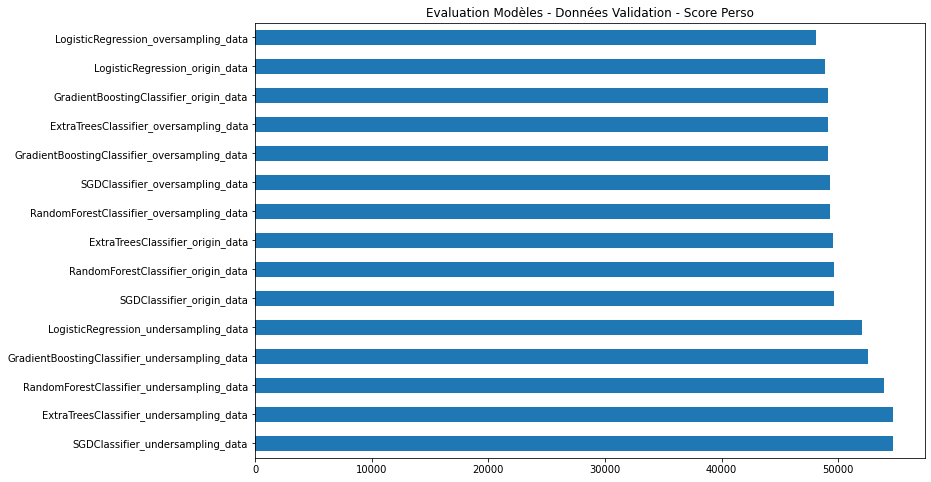

In [10]:
results_models.T.VAL_score_perso.sort_values(ascending=False).plot(
    kind = 'barh', legend=False, title='Evaluation Modèles - Données Validation - Score Perso', figsize=(12,8))

<AxesSubplot:title={'center':'Evaluation Modèles - Données Validation - Score ROC AUC'}, ylabel='ROC AUC'>

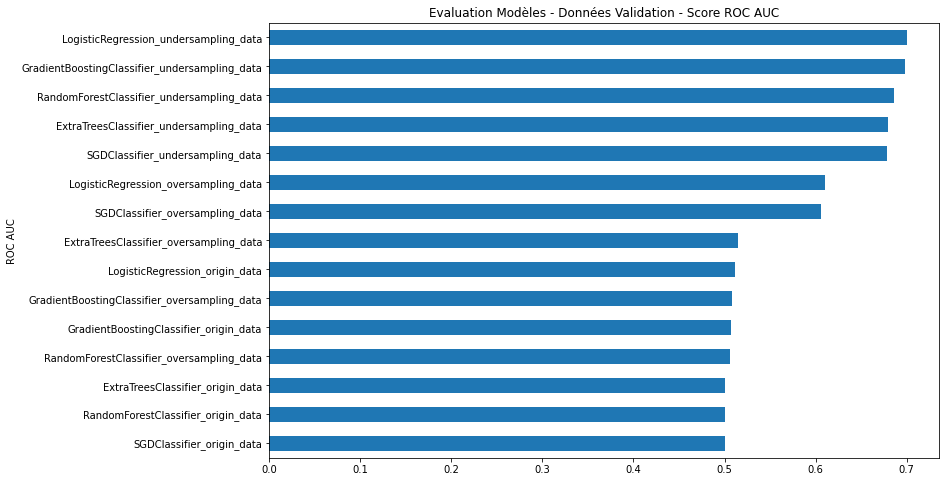

In [11]:
results_models.T.VAL_ROC.sort_values(ascending=True).plot(
    kind = 'barh', legend=False, title='Evaluation Modèles - Données Validation - Score ROC AUC', xlabel='ROC AUC', figsize=(12,8))

<AxesSubplot:title={'center':'Evaluation Modèles - Données Validation - Score Recall'}>

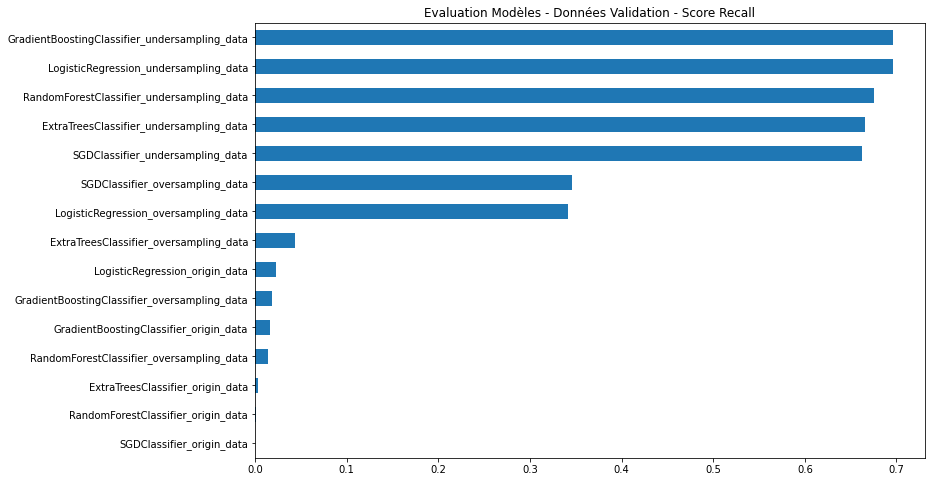

In [12]:
results_models.T.VAL_recall.sort_values(ascending=True).plot(kind = 'barh', legend=False, title='Evaluation Modèles - Données Validation - Score Recall', figsize=(12,8))

### Optimisation hyperparamétres meilleur modèle

In [8]:
X_train_original = data_train.drop(['TARGET','SK_ID_CURR'], axis=1)
y_train_original = data_train.TARGET
X_test_original = data_test.drop(['TARGET','SK_ID_CURR'], axis=1)
y_test_original = data_test.TARGET

X_train_over_balanced = data_train_over_balanced.drop(['TARGET'], axis=1)
y_train_over_balanced = data_train_over_balanced.TARGET
X_test_over_balanced = data_test_over_balanced.drop(['TARGET'], axis=1)
y_test_over_balanced = data_test_over_balanced.TARGET

X_train_under_balanced = data_train_under_balanced.drop(['TARGET'], axis=1)
y_train_under_balanced = data_train_under_balanced.TARGET
X_test_under_balanced = data_test_under_balanced.drop(['TARGET'], axis=1)
y_test_under_balanced = data_test_under_balanced.TARGET

X_val = data_val.drop(['TARGET','SK_ID_CURR'], axis=1)
y_val = data_val.TARGET

#### Logistic Regression Oversampling Data - GridSearch

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import timeit

# Choix données
X_TRAIN = X_train_over_balanced
y_TRAIN = y_train_over_balanced
X_TEST = X_test_over_balanced
y_TEST = y_test_over_balanced

# Standardisation
scaler = StandardScaler()
X_TRAIN_std = scaler.fit_transform(X_TRAIN)


# Paramètres LogisticRegression à affiner
parameters = {
    'C': [0, .25, .4, .5, .6, .75, 1],
    'penalty' : ['l1','l2','elasticnet','none'],
    'random_state': [42]}

# Création du Modèle avec recherche sur Grille et Validation Croisée
model_optimal = GridSearchCV(
    LogisticRegression(),
    param_grid = parameters, 
    cv = 5,    
    n_jobs = -1, # Utilisation de tous les CPUs en paralel
    verbose = 2)

# Apprentissage modèle
start_time = timeit.default_timer() 
model_optimal.fit(X_TRAIN_std, y_TRAIN)
elapsed = timeit.default_timer() - start_time
print("Temps d'apprentissage : {:.2f}s".format(elapsed))        

print("tuned hpyerparameters :(best parameters) ",model_optimal.best_params_)
print("accuracy :",model_optimal.best_score_)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Temps d'apprentissage : 275.39s
tuned hpyerparameters :(best parameters)  {'C': 0, 'penalty': 'none', 'random_state': 42}
accuracy : 0.8463585703040964


**Evaluation Sur données TEST**

In [65]:
# Prédictions sur le jeu TEST

X_TEST_std = scaler.transform(X_TEST)

y_test_pred = model_optimal.predict(X_TEST_std)
y_test_pred_probas = model_optimal.predict_proba(X_TEST_std)

In [26]:
# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print('precision score TEST :', precision_score(y_TEST, y_test_pred))
print('recall score TEST    :', recall_score(y_TEST, y_test_pred))
print('F1 score TEST        :', f1_score(y_TEST, y_test_pred))
print('ROC AUC score TEST   :', roc_auc_score(y_TEST, y_test_pred))
print('Score perso           :', perso_score(y_TEST, y_test_pred))
'Matrice de confusion TEST :',confusion_matrix(y_TEST, y_test_pred)

precision score TEST : 0.7070273003033367
recall score TEST    : 0.7041792547834844
F1 score TEST        : 0.7056004036326943
ROC AUC score TEST   : 0.7061933534743202
Score perso           : 16865


('Matrice de confusion VAL :',
 array([[2813, 1159],
        [1175, 2797]], dtype=int64))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

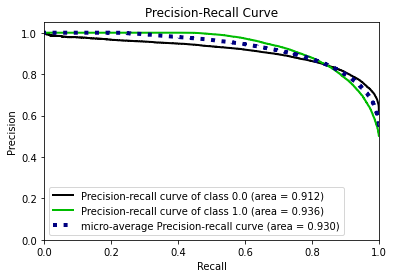

In [68]:
# Courbe Précision / Recall
from scikitplot.metrics import plot_precision_recall

fig, ax = plt.subplots()
plot_precision_recall(y_TEST, y_test_pred_probas, ax=ax)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

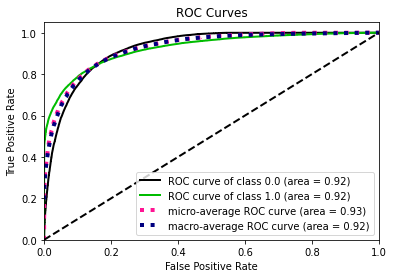

In [69]:
# Courbe ROC
from scikitplot.metrics import plot_roc

fig, ax = plt.subplots()
plot_roc(y_TEST, y_test_pred_probas, ax=ax)

**Evaluation sur données VALIDATION**

In [70]:
# Prédictions sur le jeu VALIDATION
X_val_std = scaler.transform(X_val)

y_val_pred = model_optimal.predict(X_val_std)
y_val_pred_probas = model_optimal.predict_proba(X_val_std)

In [72]:
# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print('precision score VALIDATION :', precision_score(y_val, y_val_pred))
print('recall score VALIDATION    :', recall_score(y_val, y_val_pred))
print('F1 score VALIDATION        :', f1_score(y_val, y_val_pred))
print('ROC AUC score VALIDATION   :', roc_auc_score(y_val, y_val_pred))
print('Score perso VALIDATION     :', perso_score(y_val, y_val_pred))

precision score VALIDATION : 0.19775333489351743
recall score VALIDATION    : 0.3403826787512588
F1 score VALIDATION        : 0.25016653097476127
ROC AUC score VALIDATION   : 0.6095595519052555
Score perso VALIDATION     : 48152


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

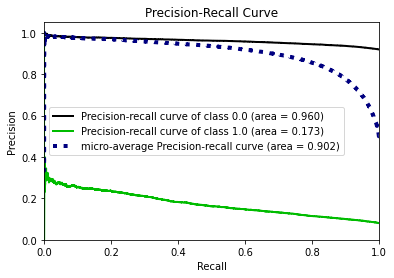

In [73]:
# Courbe Précision / Recall
from scikitplot.metrics import plot_precision_recall

fig, ax = plt.subplots()
plot_precision_recall(y_val, y_val_pred_probas, ax=ax)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

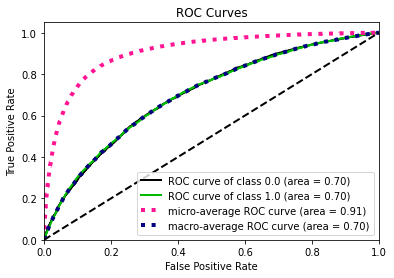

In [74]:
# Courbe ROC
from scikitplot.metrics import plot_roc

fig, ax = plt.subplots()
plot_roc(y_val, y_val_pred_probas, ax=ax)

#### GradientBoosting Udersampling Data - Hyperopt

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# Choix Données
X_TRAIN = X_train_under_balanced
y_TRAIN = y_train_under_balanced
X_TEST = X_test_under_balanced
y_TEST = y_test_under_balanced


# Prétraitement 
scaler = StandardScaler()
X_TRAIN_std = scaler.fit_transform(X_TRAIN)


# Define Parameter Space for Optimization
space = {
    'n_estimators': hp.randint('n_estimators',1000), 
    'learning_rate': hp.loguniform('learning_rate',-3,1),
    'max_depth': hp.randint('max_depth', 10),
    'max_features':  hp.randint('max_features',X_TRAIN_std.shape[1]-1),
    'min_samples_leaf': hp.randint('min_samples_leaf', 10),    
}

# Defining a Function to Minimize (Objective Function)
def hyperparameter_tuning(params):
    clf = GradientBoostingClassifier(**params)
    roc_auc = cross_val_score(clf, X_TRAIN_std, y_TRAIN,scoring="roc_auc").mean()
    return {"loss": -roc_auc, "status": STATUS_OK}

# NB: Remember that hyperopic minimizes the function, that why I add a negative sign in the acc :


# Fine Tune the Model
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

100%|██████████| 100/100 [6:07:23<00:00, 220.43s/trial, best loss: -0.7716658519009474]   
Best: {'learning_rate': 0.25414356055831405, 'max_depth': 1, 'max_features': 27, 'min_samples_leaf': 6, 'n_estimators': 795}


In [22]:
# Apprentissage avec les meilleurs HyperParamétres

best_model_GBC = GradientBoostingClassifier(n_estimators = best['n_estimators'],
                          learning_rate = best['learning_rate'],
                          max_depth = best['max_depth'],
                          max_features = best['max_features'],
                          min_samples_leaf = best['min_samples_leaf'],
                          random_state = 42)

best_model_GBC.fit(X_TRAIN_std,y_TRAIN)

GradientBoostingClassifier(learning_rate=0.25414356055831405, max_depth=1,
                           max_features=27, min_samples_leaf=6,
                           n_estimators=795, random_state=42)

**Evaluation sur données TEST**

In [62]:
# Prédictions sur le jeu TEST

X_TEST_std = scaler.transform(X_TEST)

y_test_pred = best_model_GBC.predict(X_TEST_std)
y_test_pred_probas = best_model_GBC.predict_proba(X_TEST_std)[:,1]

threshold = 0.4
y_test_pred_seuil = (y_test_pred_probas[:] >= threshold).astype('int')

In [68]:
# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print('precision score TEST :', precision_score(y_TEST, y_test_pred))
print('recall score TEST    :', recall_score(y_TEST, y_test_pred))
print('F1 score TEST        :', f1_score(y_TEST, y_test_pred))
print('ROC AUC score TEST   :', roc_auc_score(y_TEST, y_test_pred))
print('Score perso          :', perso_score(y_TEST, y_test_pred))
'Matrice de confusion TEST :',confusion_matrix(y_TEST, y_test_pred)


precision score TEST : 0.7070273003033367
recall score TEST    : 0.7041792547834844
F1 score TEST        : 0.7056004036326943
ROC AUC score TEST   : 0.7061933534743202
Score perso          : 16865


('Matrice de confusion TEST :',
 array([[2813, 1159],
        [1175, 2797]], dtype=int64))

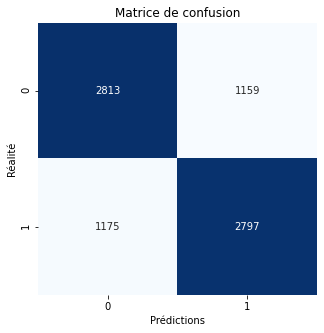

In [64]:
# Visu matrice de confusion
conf_mat = confusion_matrix(y_TEST, y_test_pred)

plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

In [67]:
# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print('precision score TEST :', precision_score(y_TEST, y_test_pred_seuil))
print('recall score TEST    :', recall_score(y_TEST, y_test_pred_seuil))
print('F1 score TEST        :', f1_score(y_TEST, y_test_pred_seuil))
print('ROC AUC score TEST   :', roc_auc_score(y_TEST, y_test_pred_seuil))
print('Score perso          :', perso_score(y_TEST, y_test_pred_seuil))
'Matrice de confusion TEST  :',confusion_matrix(y_TEST, y_test_pred_seuil)


precision score TEST : 0.6530087094220111
recall score TEST    : 0.830563947633434
F1 score TEST        : 0.7311613475177305
ROC AUC score TEST   : 0.6946122860020141
Score perso          : 13535


('Matrice de confusion TEST  :',
 array([[2219, 1753],
        [ 673, 3299]], dtype=int64))

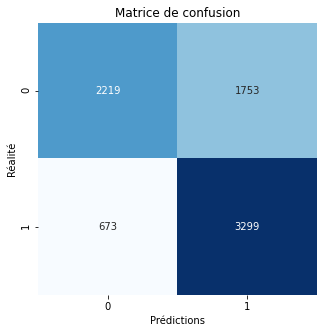

In [66]:
# Visu matrice de confusion
conf_mat = confusion_matrix(y_TEST, y_test_pred_seuil)

plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

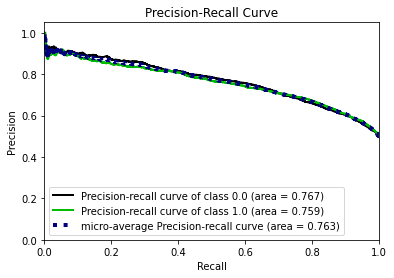

In [28]:
# Courbe Précision / Recall
from scikitplot.metrics import plot_precision_recall

fig, ax = plt.subplots()
plot_precision_recall(y_TEST, y_test_pred_probas, ax=ax)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

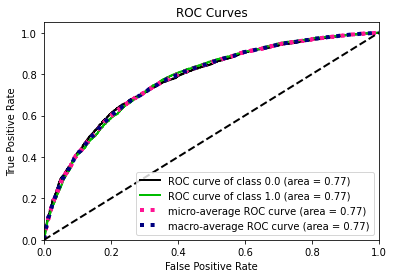

In [29]:
# Courbe ROC
from scikitplot.metrics import plot_roc

fig, ax = plt.subplots()
plot_roc(y_TEST, y_test_pred_probas, ax=ax)

**Evaluation sur données VALIDATION**

In [30]:
# Prédictions sur le jeu VALIDATION
X_val_std = scaler.transform(X_val)

y_val_pred = best_model_GBC.predict(X_val_std)
y_val_pred_probas = best_model_GBC.predict_proba(X_val_std)[:,1]

threshold = 0.4
y_val_pred_seuil = (y_val_pred_probas[:] >= threshold).astype('int')

In [69]:
# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


print('precision score VALIDATION :', precision_score(y_val, y_val_pred))
print('recall score VALIDATION    :', recall_score(y_val, y_val_pred))
print('F1 score VALIDATION        :', f1_score(y_val, y_val_pred))
print('ROC AUC score VALIDATION   :', roc_auc_score(y_val, y_val_pred))
print('Score perso VALIDATION     :', perso_score(y_val, y_val_pred))
'Matrice de confusion VALIDATION :',confusion_matrix(y_val, y_val_pred)


precision score VALIDATION : 0.17588345011846548
recall score VALIDATION    : 0.7027190332326284
F1 score VALIDATION        : 0.281348278364648
ROC AUC score VALIDATION   : 0.7067841867496758
Score perso VALIDATION     : 50945


('Matrice de confusion VALIDATION :',
 array([[40190, 16348],
        [ 1476,  3489]], dtype=int64))

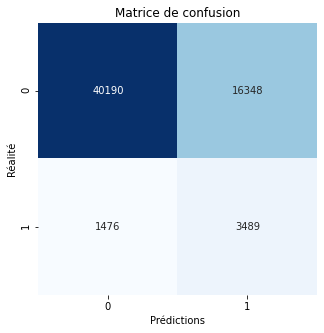

In [70]:
# Visu matrice de confusion
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

In [71]:
# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print('precision score VALIDATION :', precision_score(y_val, y_val_pred_seuil))
print('recall score VALIDATION    :', recall_score(y_val, y_val_pred_seuil))
print('F1 score VALIDATION        :', f1_score(y_val, y_val_pred_seuil))
print('ROC AUC score VALIDATION   :', roc_auc_score(y_val, y_val_pred_seuil))
print('Score perso VALIDATION     :', perso_score(y_val, y_val_pred_seuil))
'Matrice de confusion VALIDATION  :', confusion_matrix(y_val, y_val_pred_seuil)


precision score VALIDATION : 0.14108159061550815
recall score VALIDATION    : 0.8138972809667674
F1 score VALIDATION        : 0.24047845751011662
ROC AUC score VALIDATION   : 0.6893781569148104
Score perso VALIDATION     : 62485


('Matrice de confusion VALIDATION  :',
 array([[31936, 24602],
        [  924,  4041]], dtype=int64))

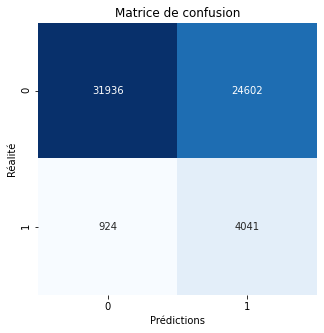

In [72]:
# Visu matrice de confusion
conf_mat = confusion_matrix(y_val, y_val_pred_seuil)

plt.figure(figsize = (5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

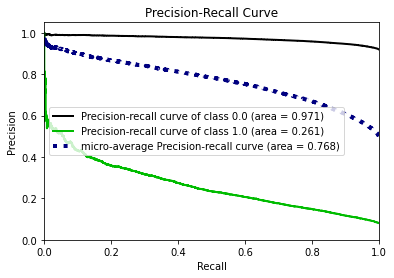

In [14]:
# Courbe Précision / Recall
from scikitplot.metrics import plot_precision_recall

fig, ax = plt.subplots()
plot_precision_recall(y_val, y_val_pred_probas, ax=ax)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

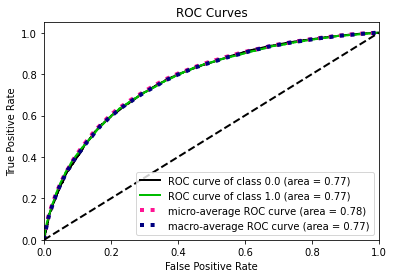

In [15]:
# Courbe ROC
from scikitplot.metrics import plot_roc

fig, ax = plt.subplots()
plot_roc(y_val, y_val_pred_probas, ax=ax)

### Entrainement du modèle sur TRAIN+TEST

### Sauvegarde du Modèle

### CHARGEMENT du Modèle

In [ ]:
# Chargement
import joblib
model_gbc = joblib.load('best_model_GradientBoostingClassifier_undersampling_data_roc_auc_score.pkl')

### Optimisation via threshold


In [35]:
from sklearn.preprocessing import StandardScaler

# Choix Données (A INTEGRER DANS UN PIPELINE)
X_TRAIN = X_train_under_balanced
y_TRAIN = y_train_under_balanced
X_TEST = X_test_under_balanced
y_TEST = y_test_under_balanced


# Prétraitement 
scaler = StandardScaler()
X_TRAIN_std = scaler.fit_transform(X_TRAIN)

In [36]:
# Prédictions sur le jeu TEST
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

X_test_std = scaler.transform(X_TEST)

y_test_pred_probas = model_gbc.predict_proba(X_test_std)

n = 0
for tr in range(0, 105, 5):
    threshold = tr/100
    y_test_pred = (y_test_pred_probas [:,1] >= threshold).astype('int')
    
    # Métriques
    score_precision = precision_score(y_TEST, y_test_pred)
    score_recall = recall_score(y_TEST, y_test_pred)
    score_f1 = f1_score(y_TEST, y_test_pred)
    score_roc = roc_auc_score(y_TEST, y_test_pred)
    score_perso = perso_score(y_TEST, y_test_pred)
    
    #### SAUVEGARDE DES RESULTATS DANS UN DATAFRAME
    
    d = {'threshold': [threshold], 'precision': [score_precision], 'recall': [score_recall], 'F1':[score_f1], 'ROC':[score_roc], 'Score_perso':[score_perso]}

    results = pd.DataFrame(data=d)  
    
    

    if n == 0:
        results_model_threshold = results    
    if n > 0:
        results_model_threshold = results_model_threshold.append(results)

    n = n+1
    
results_model_threshold


,threshold,precision,recall,F1,ROC,Score_perso
0,0.00,0.500000,1.000000,0.666667,0.500000,11916
0,0.05,0.501199,0.999748,0.667675,0.502392,11885
0,0.10,0.508738,0.996727,0.673643,0.517120,11735
0,0.15,0.525864,0.987915,0.686374,0.548590,11480
0,0.20,0.548718,0.969789,0.700873,0.586103,11388
0,0.25,0.576222,0.946878,0.716449,0.625252,11403
0,0.30,0.599834,0.909869,0.723017,0.651435,12016
0,0.35,0.625586,0.874119,0.729259,0.675478,12628
0,0.40,0.653009,0.830564,0.731161,0.694612,13535
0,0.45,0.685078,0.774421,0.727015,0.709215,14864


<AxesSubplot:xlabel='threshold'>

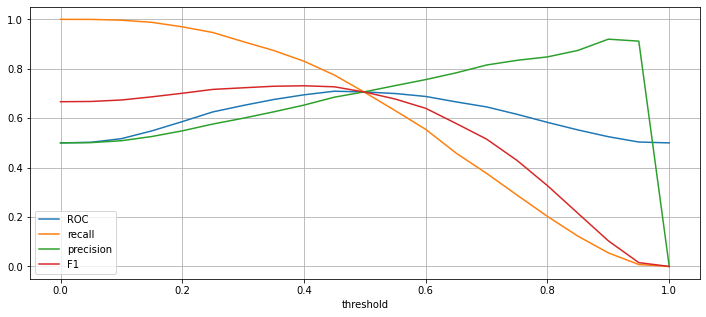

In [37]:
results_model_threshold.plot(x='threshold',y=['ROC','recall','precision','F1'],grid=True, figsize=(12,5))

<AxesSubplot:xlabel='threshold'>

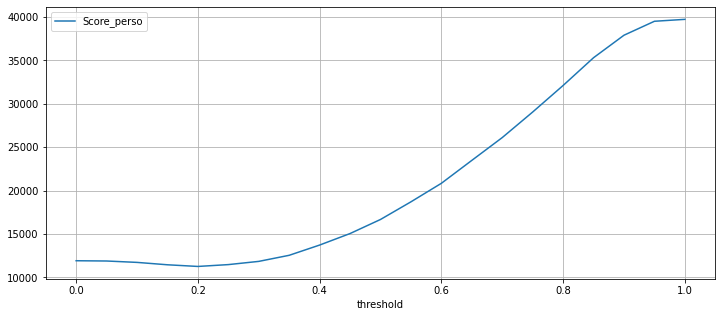

In [20]:
results_model_threshold.plot(x='threshold',y=['Score_perso'],grid=True, figsize=(12,5))

## Interprétabilité du modèle

Shap 

https://github.com/slundberg/shap/

### Features Importance Global

In [5]:
from sklearn.preprocessing import StandardScaler

# Choix Données (A INTEGRER DANS UN PIPELINE)
X_TRAIN = X_train_under_balanced
y_TRAIN = y_train_under_balanced
X_TEST = X_test_under_balanced
y_TEST = y_test_under_balanced


# Prétraitement 
scaler = StandardScaler()
X_TRAIN_std = scaler.fit_transform(X_TRAIN)

df_X_TRAIN_std = pd.DataFrame(X_TRAIN_std, columns=X_TRAIN.columns)

In [6]:
import shap

shap_values_global = shap.TreeExplainer(model_gbc).shap_values(df_X_TRAIN_std)
shap_interaction_values = shap.TreeExplainer(model_gbc).shap_interaction_values(df_X_TRAIN_std)

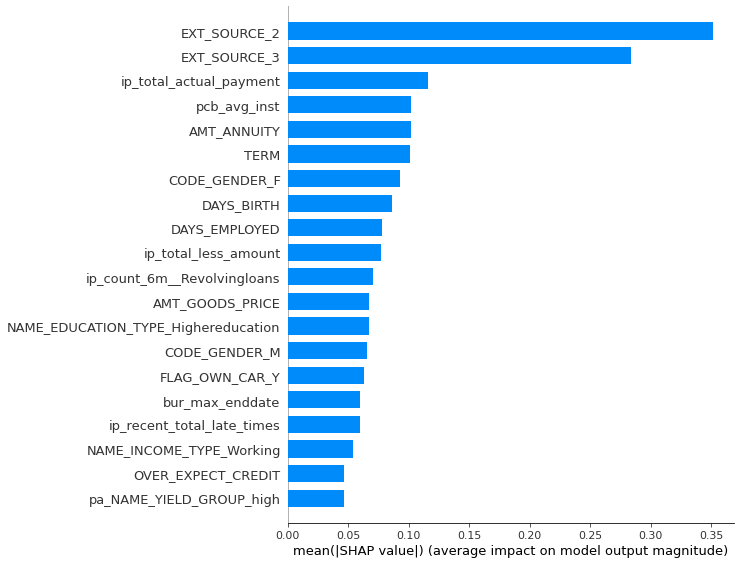

In [7]:
shap.summary_plot(shap_values_global, df_X_TRAIN_std, plot_type="bar")

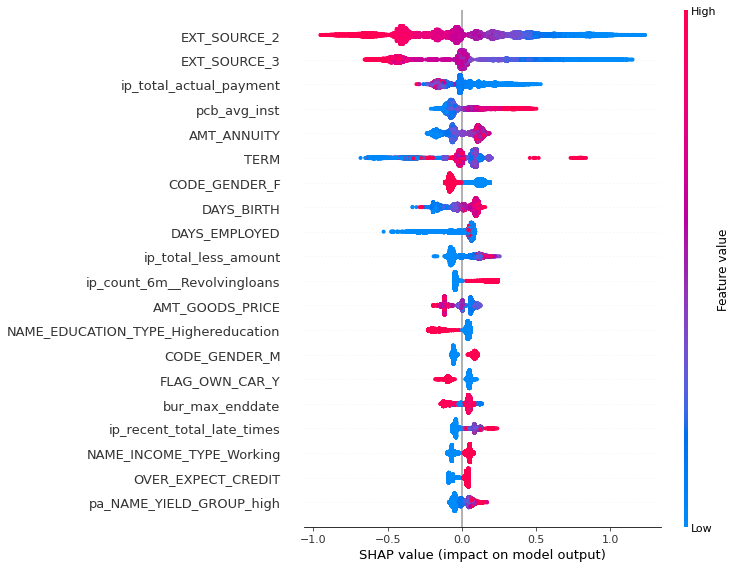

In [8]:
shap.summary_plot(shap_values_global, df_X_TRAIN_std)

### Individuel par Observation

In [11]:
from sklearn.preprocessing import StandardScaler

# Choix Données (A INTEGRER DANS UN PIPELINE)
X_TRAIN = X_train_under_balanced
y_TRAIN = y_train_under_balanced
X_TEST = X_test_under_balanced
y_TEST = y_test_under_balanced


# Prétraitement 
scaler = StandardScaler()
X_TRAIN_std = scaler.fit_transform(X_TRAIN)

In [12]:
# Prédictions sur le jeu VALIDATION
from sklearn.preprocessing import StandardScaler

X_val_std = scaler.transform(X_val)

y_val_pred = model_gbc.predict(X_val_std)
y_val_pred_probas = model_gbc.predict_proba(X_val_std)

df_X_val_std = pd.DataFrame(X_val_std, columns=X_val.columns)

In [13]:
#from scipy.special import expit, logit
# probabilites
y_val_pred_probas = model_gbc.predict_proba(X_val_std)[:,1]

threshold = 0.5
y_val_pred = (y_val_pred_probas[:] >= threshold).astype('int')

y_val_pred_model = model_gbc.predict(X_val_std)

In [14]:
import shap

explainer_individual = shap.TreeExplainer(model_gbc, model_output="raw")
shap_values_individual = explainer_individual.shap_values(X_val_std)

In [17]:
individu = 5
print('y_val_pred_probas_individu',round(y_val_pred_probas[individu],3))
print('y_val_pred avec seuil',y_val_pred[individu])
print('y_val_pred direct model',y_val_pred_model[individu])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer_individual.expected_value[0], shap_values_individual[individu,:], X_val.iloc[individu,:], link="logit")
#shap.force_plot(explainer_individual.expected_value[0], shap_values_individual[individu,:], X_val.iloc[individu,:])

y_val_pred_probas_individu 0.383
y_val_pred avec seuil 0
y_val_pred direct model 0.0


In [18]:
# fonction sigmoide appliquée au 0.06 pour retomber sur la proba 0.51


shap.force_plot(explainer_individual.expected_value[0], shap_values_individual[individu,:], X_val.iloc[individu,:])

In [17]:
# Fonction Sigmoid pour retrouver la probabilité prédite par le modèle
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [18]:
sigmoid(0.058)

0.5144959365336113

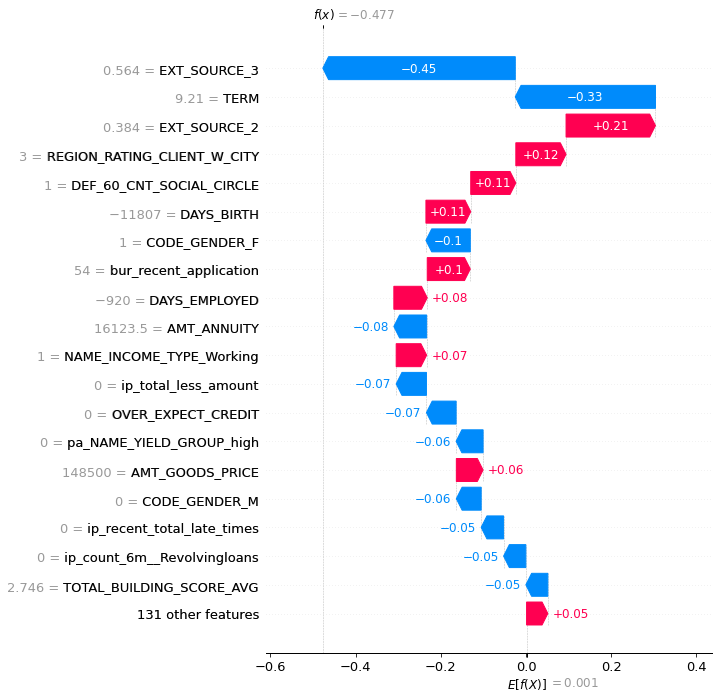

In [19]:
shap.waterfall_plot(shap.Explanation(values=shap_values_individual[individu,:],
                                     base_values=explainer_individual.expected_value[0],
                                     data=X_val.iloc[individu,:],
                                     feature_names=X_val.columns.tolist()),
                    max_display=20)